In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                if _offline:
                    if raw_acc:
                        val = list(_m["accuracy"])
                    else:
                        val = float((_m["accuracy"]).mean())

                    values[m].append(val)
                continue
                
            if normalise:    
                _ideal = offline[offline["task_index"]==1]["accuracy"]
                
                val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
                values[m].append(val)
                
            elif raw_acc:
                val = (_m["accuracy"])
                values[m].append(list(val))
                
            else:
                val = float((_m["accuracy"]).sum()/len(_m))
                    
                values[m].append(val)
    
    return values

In [3]:
def calPlasticity(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                if _offline:
                    if raw_acc:
                        val = list(target[target["train_session"]==target["task_index"]]["accuracy"])
                    else:
                        val = target[target["train_session"]==target["task_index"]]["accuracy"].mean()

                    values[m].append(val)
                continue
    
            target["train_session"] = pd.to_numeric(target["train_session"], errors='coerce')
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if normalise:    
                _ideal = offline["accuracy"]
                val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
                values[m].append(val)
                
            elif raw_acc:
                val = (_m["accuracy"])
                values[m].append(list(val))
            else:
                val = float((_m["accuracy"]).sum()/len(_m))    
                values[m].append(val)
                
            
    
    return values

In [4]:
def calOverallAcc(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            _m = target[target["train_session"]==str(len(task_index))]
            for t in task_index:
                t = int(t)
                _m1 = _m[_m["task_index"]==t]["accuracy"]
                assert len(_m1)==1

                if normalise:
                    _ideal = offline[offline["task_index"]==t]["accuracy"]
                    _sum += float(_m1)/float(_ideal)
                    
                elif raw_acc:
                    _sum.append(float(_m1))
                    
                else:
                    _sum += float(_m1)

            if raw_acc:
                values[m].append(_sum)
                continue
                
                
            if len(train_session)==0:
                values[m].append(np.nan)
            else:
                val = _sum/len(train_session)
                values[m].append(val)
    
    return values

In [5]:
# Overall accuracy at each step
def calOverallAccEach(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline" and (not _offline):
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            target["train_session"] = pd.to_numeric(target["train_session"], errors='coerce')
            
            val = []
            for s in train_session:
                s = int(s)
                
                _m = target[target["train_session"]==(s)]
                _sum = _m["accuracy"].sum()/len(_m)
                val.append(_sum)
                
            values[m].append(val)
                
    return values

In [7]:
all_values = {}
for d in ["CASAS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_no_of_hidden/"
    _folder = "../../Results/"+dataset+"/exp_offline_acc/"
    
    raw = pd.read_csv(folder+"results.txt")
    _raw = pd.read_csv(_folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    _raw.columns = [c.strip() for c in raw.columns]

    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method, raw_acc=True)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method, raw_acc=True)
        plasticity.append(m)
        
        m = calOverallAccEach(target, task_order, method, raw_acc=True)
        overallAcc.append(m)
        
    print(d, "DONE")
        
    all_values[d] = (stability, plasticity, overallAcc)

CASAS DONE


# Continual learning 

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plotline(values, label, x=[], models=None, legends=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    if legends is None:
        legends = models
        
    numbers = []
    for model in models:
        nTaskOrder = len(values[model])
        nTask = len(values[model][0])
        
        _pivot = [[] for i in range(nTask)]
        for i in range(nTaskOrder):
            for j in range(nTask):
                _pivot[j].append(values[model][i][j])
        
        avg = [(np.nanmean(v), stats.sem(v, nan_policy="omit")) for v in _pivot]
        numbers.append(avg)

    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        mval = [v for (v, _) in numbers[i]]
        merr = [e for (_, e) in numbers[i]]
        print(x, model, mval)
        ax.errorbar(x, mval, yerr=merr, fmt=patterns[i])

        mx = [v+e for (v, e) in numbers[i]]
        mn = [v-e for (v, e) in numbers[i]]
        
#         ax.fill_between(x, mn, mx, alpha=0.2)

    ax.set_ylim(ymin=-0.1, ymax=1.1)
    ax.set_title(label)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend(legends, prop={'size': 20}, loc=3, bbox_to_anchor=(1, 0.4))
#     ax.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)


    fig.tight_layout()

    plt.show()

In [9]:

# select the best model (best GAN and best hidden units) => "sg-cgan" with highest number of neuron
def selectModel(db, model, cmd):
    (stability, plasticity, overallAcc) = all_values[db]
    
    models = [model, "exact", "none"]
    legends = ["HAR-GAN", "Exact Reply", "None"]
    
    x = [1,2,3,4,5]
    if db=="HouseA":
        x = [1,2,3]
    
#     stability[cmd]["batch"] = []
#     plasticity[cmd]["batch"] = []
#     overallAcc[cmd]["batch"] = []
#     for i in range(len(stability[cmd]["offline"])):
#         v = stability[cmd]["offline"][i]
#         stability[cmd]["batch"].append([v[-1] for i in v])
        
#         v = plasticity[cmd]["offline"][i]
#         plasticity[cmd]["batch"].append([v[-1] for i in v])
        
#         v = overallAcc[cmd]["offline"][i]
#         overallAcc[cmd]["batch"].append([v[-1] for i in v])
        
    plotline(stability[cmd], "Stability of the model", x=x, models=models, legends=legends)
    plotline(plasticity[cmd], "Plasticity of the model", x=x, models=models, legends=legends)
    plotline(overallAcc[cmd], "Overall performance", x=x, models=models, legends=legends)

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.767592708016621, 0.7547442738421, 0.7206784230262492, 0.673687595013682]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239342632005677, 0.841751431539475, 0.8110071070234113, 0.7518124556602818]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.00953846153846154, 0.0, 0.0, 0.0]


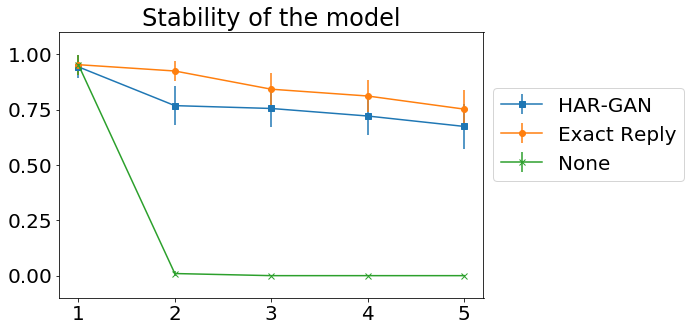

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.9105986463096437, 0.7037246753246753, 0.6738112546873417, 0.7601616028898638]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9238964771830457, 0.9024883116883116, 0.9845672342150603, 0.9728326492348233]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.9468766798418973, 0.9366943722943724, 0.9977136363636363, 0.9847803030303031]


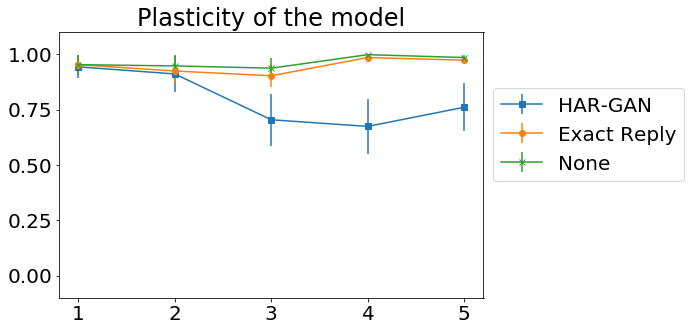

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.8390956771631325, 0.7726834183847986, 0.702036358392394, 0.6874172245184337]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239153701918065, 0.8857727595356728, 0.863886243408983, 0.854672230463288]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.4782075706901794, 0.3122314574314574, 0.2526784090909091, 0.19841693017127798]


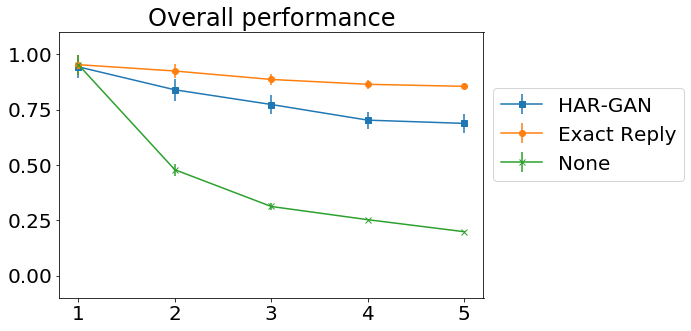

In [10]:
selectModel("CASAS", "sg-cgan", 3)

In [37]:
task_orders = [
    ["R2_dinner", "R2_lunch", "R2_sleeppppp", "R1_sleep", "R2_toilet", "R1_work_dining_room_table", "R1_work_computer", "R2_watch_TV", "R1_toilet", "R2_work_computer"],
    ["R2_sleeppppp", "R2_toilet", "R2_lunch", "R2_dinner", "R2_watch_TV", "R1_work_dining_room_table", "R2_work_computer", "R1_work_computer", "R1_toilet", "R1_sleep"],
    ["R1_toilet", "R2_lunch", "R1_work_computer", "R2_dinner", "R2_work_computer", "R1_work_dining_room_table", "R2_toilet", "R2_watch_TV", "R2_sleeppppp", "R1_sleep"],
    ["R1_toilet", "R2_lunch", "R2_sleeppppp", "R1_work_computer", "R2_dinner", "R2_watch_TV", "R2_toilet", "R1_sleep", "R1_work_dining_room_table", "R2_work_computer"],
    ["R2_dinner", "R1_work_dining_room_table", "R2_watch_TV", "R1_work_computer", "R2_work_computer", "R1_toilet", "R1_sleep", "R2_sleeppppp", "R2_lunch", "R2_toilet"],
    ["R2_watch_TV", "R1_work_computer", "R2_dinner", "R1_toilet", "R2_toilet", "R2_work_computer", "R2_sleeppppp", "R2_lunch", "R1_work_dining_room_table", "R1_sleep"],
    ["R2_dinner", "R2_sleeppppp", "R2_watch_TV", "R1_sleep", "R2_toilet", "R1_work_dining_room_table", "R1_work_computer", "R2_lunch", "R1_toilet", "R2_work_computer"],
    ["R1_work_computer", "R2_work_computer", "R1_sleep", "R2_toilet", "R2_lunch", "R2_dinner", "R1_toilet", "R2_sleeppppp", "R2_watch_TV", "R1_work_dining_room_table"],
    ["R1_sleep", "R1_work_dining_room_table", "R1_work_computer", "R1_toilet", "R2_sleeppppp", "R2_toilet", "R2_watch_TV", "R2_dinner", "R2_work_computer", "R2_lunch"],
    ["R1_work_dining_room_table", "R1_toilet", "R2_sleeppppp", "R2_lunch", "R2_work_computer", "R2_dinner", "R1_sleep", "R2_toilet", "R2_watch_TV", "R1_work_computer"],
]


In [38]:
(stability, plasticity, overallAcc) = all_values["CASAS"]
values = plasticity[3]["sg-cgan"]

print()
for i in range(len(values)):
    for j in range(len(values[0])):
        
        print(task_orders[i][j*2][3:9], task_orders[i][j*2+1][3:9], end='')  
        if values[i][j] > 0.4:
#             print(" ", end='  ')
            print("     -".format(values[i][j]), end='  ')
        else:
            print("{0:.4f}".format(values[i][j]), end='  ')
#             print("*", end='  ')
    
    print("")
#     print ("======")


dinner lunch     -  sleepp sleep     -  toilet work_d     -  work_c watch_     -  toilet work_c     -  
sleepp toilet     -  lunch dinner0.1800  watch_ work_d     -  work_c work_c     -  toilet sleep     -  
toilet lunch     -  work_c dinner     -  work_c work_d     -  toilet watch_     -  sleepp sleep     -  
toilet lunch     -  sleepp work_c     -  dinner watch_     -  toilet sleep     -  work_d work_c     -  
dinner work_d     -  watch_ work_c     -  work_c toilet0.0233  sleep sleepp     -  lunch toilet     -  
watch_ work_c     -  dinner toilet     -  toilet work_c     -  sleepp lunch     -  work_d sleep     -  
dinner sleepp     -  watch_ sleep     -  toilet work_d     -  work_c lunch0.0390  toilet work_c     -  
work_c work_c     -  sleep toilet     -  lunch dinner0.1100  toilet sleepp     -  watch_ work_d0.0486  
sleep work_d     -  work_c toilet     -  sleepp toilet     -  watch_ dinner     -  work_c lunch     -  
work_d toilet     -  sleepp lunch     -  work_c dinner     -  s